In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/All_not_null/55285839-9b78-48d8-9f4e-573190ace016_data.csv").sort_values('created_at')

target = data[['imbalance_health']]
# 데이터셋의 4번째 컬럼부터 마지막에서 앞으로 6번째 컬럼까지가 유효한 특성들임
data = data.iloc[:,4:-6]

raw_target = target.values
raw_data = data.values

In [3]:
# Split into train and test datasets
train_data, test_data, train_labels, test_labels = train_test_split(raw_data, raw_target, test_size=0.2, random_state=42)

In [4]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)
# autoencoder는 레이블이 필요없음
# train_labels = scaler.fit_transform(train_labels)
# test_labels = scaler.fit_transform(test_labels)

In [5]:
# Verify the dimensions
print(f"train_data shape: {train_data.shape}")
print(f"test_data shape: {test_data.shape}")

train_data shape: (2012, 38)
test_data shape: (503, 38)


In [6]:
# 기준값 설정
threshold = 1

# 실수 값을 기준으로 boolean 마스크 생성
normal_train_mask = train_labels.squeeze() >= threshold  # 정상 데이터: 값이 1 이상
anomaly_train_mask = train_labels.squeeze() < threshold   # 비정상 데이터: 값이 1 미만

normal_test_mask = test_labels.squeeze() >= threshold
anomaly_test_mask = test_labels.squeeze() < threshold

# 데이터 구분
normal_train_data = train_data[normal_train_mask]
anomaly_train_data = train_data[anomaly_train_mask]

normal_test_data = test_data[normal_test_mask]
anomaly_test_data = test_data[anomaly_test_mask]

In [7]:
# Verify the dimensions
print(f"normal_train_data shape: {normal_train_data.shape}")
print(f"normal_test_data shape: {normal_test_data.shape}")
print(f"anomaly_train_data shape: {anomaly_train_data.shape}")
print(f"anomaly_test_data shape: {anomaly_test_data.shape}")

normal_train_data shape: (1850, 38)
normal_test_data shape: (462, 38)
anomaly_train_data shape: (162, 38)
anomaly_test_data shape: (41, 38)


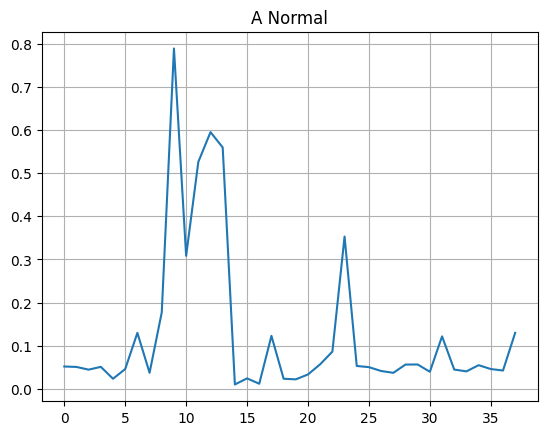

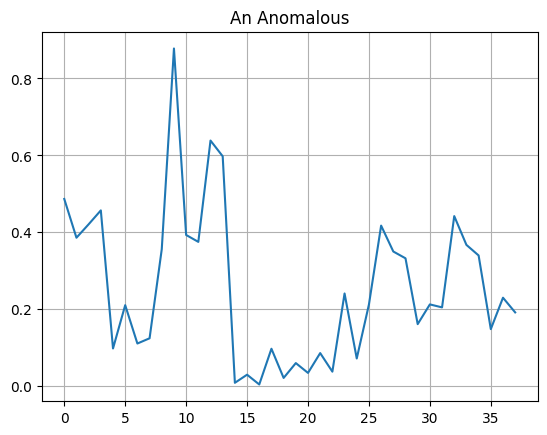

In [8]:
# Plot data
plt.grid()
plt.plot(np.arange(38), normal_train_data[0])
plt.title("A Normal")
plt.show()

plt.grid()
plt.plot(np.arange(38), anomaly_train_data[0])
plt.title("An Anomalous")
plt.show()


In [9]:
import torch.nn as nn

class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(38, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 38),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
autoencoder = AnomalyDetector()

In [10]:
# Loss function and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [11]:
normal_train_data = torch.Tensor(normal_train_data)
test_data = torch.Tensor(test_data)

normal_test_data = torch.Tensor(normal_test_data)
anomaly_train_data = torch.Tensor(anomaly_train_data)
anomaly_test_data = torch.Tensor(anomaly_test_data)



In [13]:
import torch

num_epochs = 500
batch_size = 512

train_dataset = torch.utils.data.TensorDataset(normal_train_data, normal_train_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_data, test_data)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

best_loss = float('inf')  # Initialize best_loss to infinity

for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        outputs = autoencoder(inputs)

        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}")

    # Save the model if the current loss is lower than the best loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(autoencoder.state_dict(), 'best_autoencoder.pth')
        print(f"Model saved with loss: {best_loss}")


In [14]:
# After training, validate the model on test data
model_path = 'best_autoencoder.pth'
autoencoder.load_state_dict(torch.load(model_path,  weights_only=True, map_location='cuda'))
autoencoder.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, _ = data
        outputs = autoencoder(inputs)

# Plot training and validation loss (simplified here)
# Just tracking training loss for this example

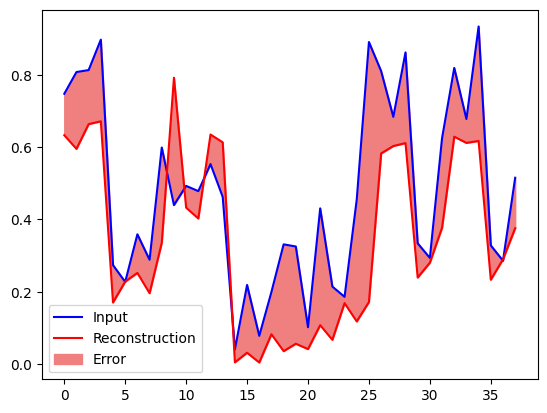

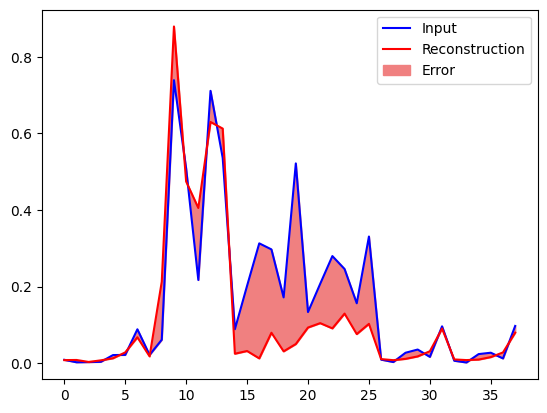

In [15]:
# Test reconstructions for normal data
with torch.no_grad():
    encoded_data = autoencoder.encoder(normal_test_data)
    decoded_data = autoencoder.decoder(encoded_data)

plt.plot(normal_test_data[0].numpy(), 'b')
plt.plot(decoded_data[0].numpy(), 'r')
plt.fill_between(np.arange(38), decoded_data[0].numpy(), normal_test_data[0].numpy(), color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# Test reconstructions for anomalous data
with torch.no_grad():
    encoded_data = autoencoder.encoder(anomaly_test_data)
    decoded_data = autoencoder.decoder(encoded_data)

plt.plot(anomaly_test_data[0].numpy(), 'b')
plt.plot(decoded_data[0].numpy(), 'r')
plt.fill_between(np.arange(38), decoded_data[0].numpy(), anomaly_test_data[0].numpy(), color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()
